# Assignment 1 2AMM10 2023-2024

## Group: [35]
### Member 1: [Czaplicki, Michal]
### Member 2: [Dongen, Johan van]
### Member 3: [Mudragel, Dmytro]

# Data Preparation

## Data Loading

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# function for loading the training data:

def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    path = '/content/drive/MyDrive/'
    with open(path + file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

In [4]:
train_data = load_data('train_data.pkl')

## Data Overview

In [5]:
def count_total_images(data):
    """
    Count the total number of images in the provided data.
    Parameters:
        data (dict): The dictionary containing the image data.
    Returns:
        int: The total number of images.
    """
    total_images = 0
    for alphabet in data.keys():
        for character in data[alphabet].keys():
            total_images += len(data[alphabet][character])
    return total_images

def display_image(data, alphabet_id, character_id, image_id):
    """
    Display a single image from the provided data.
    """
    alphabet = list(data.keys())[alphabet_id]
    character = list(data[alphabet].keys())[character_id]
    image = data[alphabet][character][image_id]
    plt.imshow(np.squeeze(image))
    plt.title(f"Alphabet: {alphabet}, Character: {character}, Image ID: {image_id}")
    plt.axis('off')
    plt.show()

def count_total_characters_per_alphabet(data):
    """
    Count the total number of unique characters in each alphabet of the provided data.
    Parameters:
        data (dict): The dictionary containing the image data.
    Returns:
        dict: A dictionary where keys are alphabets and values are the count of unique characters in each alphabet.
    """
    total_characters_per_alphabet = {}
    for alphabet in data.keys():
        total_characters_per_alphabet[alphabet] = len(data[alphabet].keys())
    return total_characters_per_alphabet

In [6]:

total_characters_per_alphabet = count_total_characters_per_alphabet(train_data)
for alphabet, count in total_characters_per_alphabet.items():
    print(f"Alphabet: {alphabet}, Total unique characters: {count}")


total_unique_characters = sum(total_characters_per_alphabet.values())
print(f"Total number of unique characters across all alphabets: {total_unique_characters}")

total_images = count_total_images(train_data)
print(f"Total number of images: {total_images}")


Alphabet: Alphabet_of_the_Magi, Total unique characters: 20
Alphabet: Anglo-Saxon_Futhorc, Total unique characters: 29
Alphabet: Arcadian, Total unique characters: 26
Alphabet: Armenian, Total unique characters: 41
Alphabet: Asomtavruli_(Georgian), Total unique characters: 40
Alphabet: Balinese, Total unique characters: 24
Alphabet: Bengali, Total unique characters: 46
Alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics), Total unique characters: 14
Alphabet: Braille, Total unique characters: 26
Alphabet: Burmese_(Myanmar), Total unique characters: 34
Alphabet: Cyrillic, Total unique characters: 33
Alphabet: Early_Aramaic, Total unique characters: 22
Alphabet: Futurama, Total unique characters: 26
Alphabet: Grantha, Total unique characters: 43
Alphabet: Greek, Total unique characters: 24
Alphabet: Gujarati, Total unique characters: 48
Alphabet: Hebrew, Total unique characters: 22
Alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics), Total unique characters: 16
Alphabet: Japanese_(hiragan

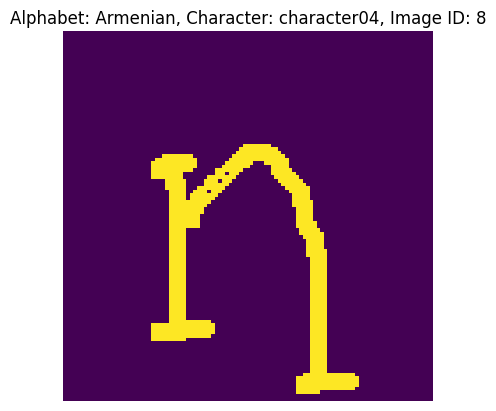

In [7]:
display_image(train_data, 3, 3, 8)

In [8]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.

# see the code below for examples of working with the train data

alphabets = list(train_data.keys())
print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2
print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


In [9]:
# function for plotting some examples:

def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)

    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()

<Figure size 640x480 with 0 Axes>

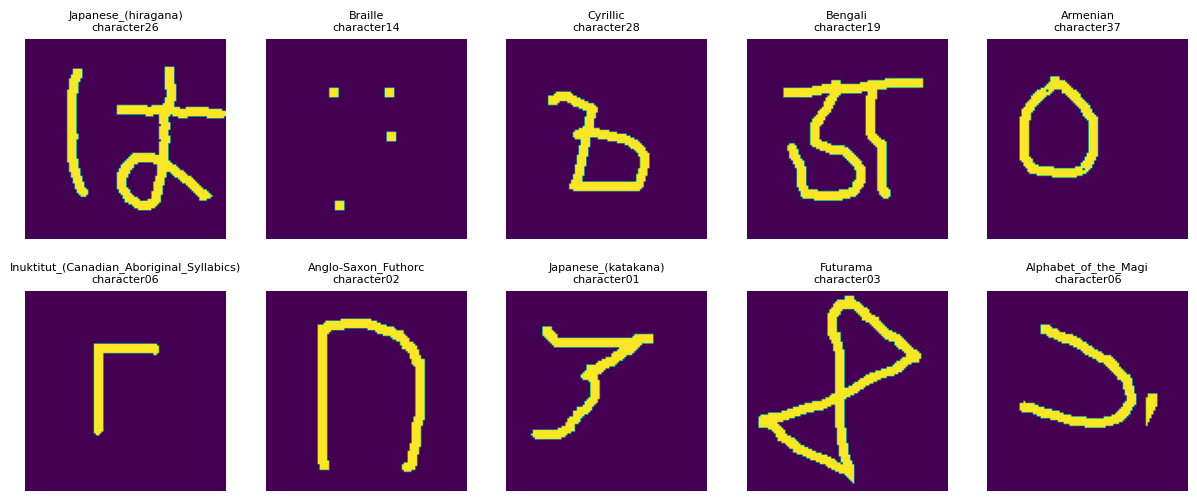

In [10]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

## Data Preparation

In [11]:
# Prepare dataset
def process_data(data, transform):
  alphabets = list(data.keys())
  x = []
  y = []
  alphabet_counts = []
  image_count_per_class = [] # 20 images per class
  count = 0
  for alphabet in alphabets:
    characters_for_this_alphabet = list(train_data[alphabet].keys())
    alphabet_counts.append(len(characters_for_this_alphabet))
    for character in characters_for_this_alphabet:
      image_count = 0
      for image in data[alphabet][character]:
        image_count +=1
        # transform = T.Resize(32)
        x.append(transform(image))
        # x.append(image)
        y.append(count)
        # y.append(character)
      image_count_per_class.append(image_count)
      count += 1
  return x, y, alphabet_counts, image_count_per_class

In [12]:
def create_label_dict(labels):
  count = 0
  result = {}
  for label in labels:
    if label in result:
      continue
    result[label] = count
    result[count] = label # Bijective dict - Assuming label and count values dont overlap
    count += 1
  return result

def process_test_data(test_data, alphabet):
  x_train = []
  y_train = []
  labels = test_data['annotated_images_labels'][alphabet]
  label_dict = create_label_dict(labels)

  transform = T.Resize(32)
  for c in range(len(test_data['annotated_images'][alphabet])):

    x_train.append(transform(test_data['annotated_images'][alphabet][c]))
    y_train.append(label_dict[test_data['annotated_images_labels'][alphabet][c]])

  x_valid = []
  y_valid = []
  for c in range(len(test_data['unseen_images'][alphabet])):
    x_valid.append(transform(test_data['unseen_images'][alphabet][c]))
    y_valid.append(label_dict[test_data['unseen_images_labels'][alphabet][c]])
  return x_train, y_train, x_valid, y_valid, label_dict

In [13]:
from torch.utils.data.sampler import BatchSampler
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        # print(self.batch_size, self.n_dataset)
        # print(self.labels_set)
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [14]:
resize = T.Resize(32)
transform_task1 = T.Compose([resize])
x_train, y_train, info, info2 = process_data(train_data, transform_task1)

In [15]:
from torch.utils.data import DataLoader, TensorDataset

train_batch_sampler = BalancedBatchSampler(y_train, n_classes=200, n_samples=10)
triplets_train_loader = torch.utils.data.DataLoader(TensorDataset( torch.stack(x_train), torch.stack([torch.tensor(x) for x in y_train]) ), batch_sampler=train_batch_sampler)

# Task 1: Character recognition

## Model Training

In [16]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()


        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]

        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

In [17]:
from itertools import combinations

def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix
class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))
class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()

        self.margin = margin

   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):

        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None


    def get_triplets(self, embeddings, labels):

        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)


            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()

                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)

In [18]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class CharacterNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.front_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # out 16

        # Conv Layer block 2
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #out 8


        # Conv Layer block 3
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #out 4

        Lambda(lambda x: x.view(x.size(0), -1)),

        nn.Linear(4*4*64, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
    )
    self.last_layer = nn.Linear(1024, 964)
    #self.last_layer = nn.Linear(1024, len(all_chars))
    # self.last_layer = nn.Linear(1024, 100)
  def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x

In [19]:
import numpy as np
from tqdm import tqdm

class Trainer():
    def __init__(self,model: torch.nn.Module,device: torch.device,criterion: torch.nn.Module,optimizer: torch.optim.Optimizer,training_DataLoader: torch.utils.data.Dataset,epochs: int):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.device = device
        self.epochs = epochs
    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode
            train_losses=[]
            for batch in self.training_DataLoader:
                x,y=batch
                # print(len(x))
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss

                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            print(f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}\n',end=' ')
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')

In [20]:

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
# device=torch.device('cpu')

mined_embedding_net = CharacterNet()
mined_model = mined_embedding_net.to(device)
margin=1
criterion = TripletLoss(margin,  Informative_Negative_TripletSelector(margin))
optimizer = torch.optim.SGD(mined_model.parameters(), lr=0.1, momentum=0.9)
trainer = Trainer(model=mined_model,device=device,criterion=criterion,optimizer=optimizer,training_DataLoader=triplets_train_loader,
                  # validation_DataLoader=triplets_test_loader,
                  epochs=10)
trainer.run_trainer() # start training

 10%|█         | 1/10 [01:21<12:09, 81.06s/it]

EPOCH: 01/10
 LOSS: 1.0014 

 20%|██        | 2/10 [02:34<10:11, 76.39s/it]

EPOCH: 02/10
 LOSS: 1.2059 

 30%|███       | 3/10 [03:42<08:28, 72.68s/it]

EPOCH: 03/10
 LOSS: 1.1370 

 40%|████      | 4/10 [04:51<07:08, 71.41s/it]

EPOCH: 04/10
 LOSS: 1.2228 

 50%|█████     | 5/10 [05:59<05:49, 69.88s/it]

EPOCH: 05/10
 LOSS: 1.1308 

 60%|██████    | 6/10 [07:02<04:30, 67.56s/it]

EPOCH: 06/10
 LOSS: 1.0908 

 70%|███████   | 7/10 [08:06<03:19, 66.51s/it]

EPOCH: 07/10
 LOSS: 1.1069 

 80%|████████  | 8/10 [09:12<02:12, 66.49s/it]

EPOCH: 08/10
 LOSS: 1.0532 

 90%|█████████ | 9/10 [10:16<01:05, 65.54s/it]

EPOCH: 09/10
 LOSS: 1.0578 

100%|██████████| 10/10 [11:27<00:00, 68.79s/it]

EPOCH: 10/10
 LOSS: 1.0700 

## Evaluation Of The Model

In [21]:
# load the test data:

data_dict_test = load_data('test_data_task1.pkl')
# keys are 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'.
# These keys correspond to the annotated images with known labels for each test alphabet (the sets A);
# labels of the images with known labels for each test alphabet;
# to-be-labeled unseen images for each test alphabet (sets U);
# and labels of the to-be-labeled unseen images for each alphabet, respectively.
# For each alphabet, the labels of the unseen images should be predicted by the model.
# The true labels of the unseen images can only be used to calculate evaluation metrics.
print(data_dict_test.keys())

dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])


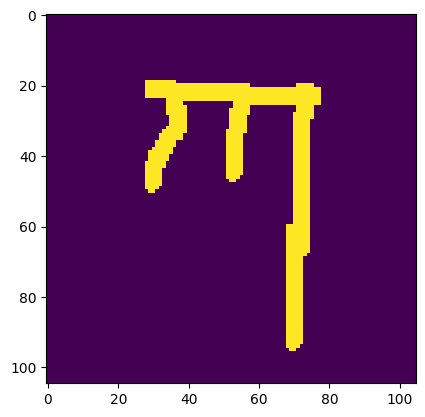

In [22]:
type(data_dict_test['unseen_images'])
data_dict_test['unseen_images'].keys()
data_dict_test['unseen_images']['Tibetan'][4,0,...]
plt.imshow(data_dict_test['unseen_images']['Tibetan'][4,0,...])

In [23]:
def val(test_data, model, alphabet, k=8):
  x_test_train, y_test_train, x_test_valid, y_test_valid, label_dict = process_test_data(test_data, alphabet)
  counts = [0 for _ in range(k)]
  count = 0

  train_outputs = [ ]
  model.eval()  # evaluation mode
  with torch.no_grad():


    for train_idx in range(len(x_test_train)):
      train_outputs.append(model(x_test_train[train_idx].unsqueeze(0)))
    for test_idx in range(len(x_test_valid)):
      # Check distance for query in relation to all other images in the known train set
      distances = []
      output2 = model(x_test_valid[test_idx].unsqueeze(0))
      for train_idx in range(len(x_test_train)):
        # dist = siamese.get_distance(x_test_train[train_idx].unsqueeze(0), x_test_valid[test_idx].unsqueeze(0))
        # dist = siamese.get_distance2(train_outputs[train_idx], x_test_valid[test_idx].unsqueeze(0))
        dist = (train_outputs[train_idx] - output2).pow(2).sum(1)
        distances.append(dist.item())

      value, index = torch.topk(torch.tensor(distances), k, largest=False)
      # print(f"ytrue: {y_test_valid[test_idx]} pred: {index}")
      for i in range(k):
        if (y_test_valid[test_idx] in index[:i+1]):
            counts[i] += 1
  return [counts, len(x_test_valid), [c/len(x_test_valid) for c in counts]]


def calculate_accuracy(test_data, model, k):
  result = []
  counts = [0 for _ in range(k)]
  total = 0
  alphabets = list(test_data['unseen_images'].keys())
  for alphabet in alphabets[::-1]:
    alphabet_result = val(test_data, model, alphabet, k)
    counts = [sum(x) for x in zip(counts, alphabet_result[0])]
    total += alphabet_result[1]
    print(f"{[counts, total, [round(c/total, 2) for c in counts]]}")
  return [round(c/total, 2) for c in counts]


result = calculate_accuracy(data_dict_test, mined_embedding_net, 8)
print(result)

[[366, 442, 465, 471, 477, 482, 484, 484], 494, [0.74, 0.89, 0.94, 0.95, 0.97, 0.98, 0.98, 0.98]]
[[911, 1118, 1183, 1211, 1230, 1242, 1250, 1253], 1292, [0.71, 0.87, 0.92, 0.94, 0.95, 0.96, 0.97, 0.97]]
[[1262, 1526, 1620, 1661, 1686, 1706, 1715, 1719], 1767, [0.71, 0.86, 0.92, 0.94, 0.95, 0.97, 0.97, 0.97]]
[[1569, 1870, 1998, 2057, 2096, 2126, 2142, 2150], 2204, [0.71, 0.85, 0.91, 0.93, 0.95, 0.96, 0.97, 0.98]]
[[1867, 2260, 2442, 2533, 2584, 2631, 2655, 2666], 2736, [0.68, 0.83, 0.89, 0.93, 0.94, 0.96, 0.97, 0.97]]
[[2297, 2846, 3105, 3250, 3326, 3389, 3433, 3457], 3610, [0.64, 0.79, 0.86, 0.9, 0.92, 0.94, 0.95, 0.96]]
[[3002, 3651, 3931, 4082, 4164, 4229, 4276, 4303], 4465, [0.67, 0.82, 0.88, 0.91, 0.93, 0.95, 0.96, 0.96]]
[[3438, 4164, 4474, 4631, 4718, 4786, 4836, 4868], 5035, [0.68, 0.83, 0.89, 0.92, 0.94, 0.95, 0.96, 0.97]]
[[3866, 4695, 5057, 5255, 5360, 5444, 5504, 5550], 5795, [0.67, 0.81, 0.87, 0.91, 0.92, 0.94, 0.95, 0.96]]
[[4448, 5416, 5843, 6069, 6202, 6300, 6370, 6419

In [24]:
def calculate_accuracy(test_data, model, k):
  result = []
  counts = [0 for _ in range(k)]
  total = 0
  alphabets = list(test_data['unseen_images'].keys())
  for alphabet in alphabets[::-1]:
    alphabet_result = val(test_data, model, alphabet, k)
    counts = [sum(x) for x in zip(counts, alphabet_result[0])]
    total += alphabet_result[1]
    #print(f"{[counts, total, [round(c/total, 2) for c in counts]]}")
  return [round(c/total, 2) for c in counts]

To evaluate the model against a random guessing baseline, we can create a function that generates random predictions and calculates the top-k accuracy. Here's how you can do it:

In [25]:
def random_baseline(test_data, k_values=[1, 2, 3, 4, 5, 6, 7, 8]):
    alphabets = list(test_data['unseen_images'].keys())
    total = 0
    counts = {k: 0 for k in k_values}

    for alphabet in alphabets[::-1]:
        x_test_train, y_test_train, x_test_valid, y_test_valid, label_dict = process_test_data(test_data, alphabet)
        total += len(x_test_valid)

        for test_idx in range(len(x_test_valid)):
            # Generate random predictions
            random_predictions = torch.randint(0, len(x_test_train), (max(k_values),))
            for k in k_values:
                # Check if the true label is in the top-k random predictions
                if y_test_valid[test_idx] in random_predictions[:k]:
                    counts[k] += 1
    accuracies = []
    # Calculate top-k accuracy for each k
    #accuracies = {k: round(counts[k] / total, 2) for k in k_values}
    for k in k_values:
        accuracies.append(round(counts[k] / total, 2))
    #for k in k_values:
    #  print(round(counts[k]),total)
    return accuracies

random_baseline_result = random_baseline(data_dict_test)
print(random_baseline_result)

[0.03, 0.06, 0.09, 0.12, 0.15, 0.17, 0.2, 0.22]


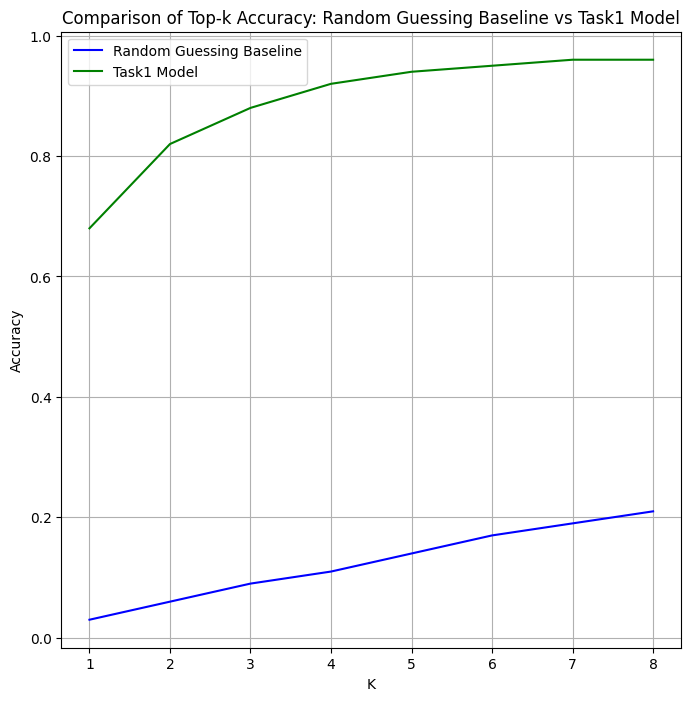

In [26]:
random_baseline_result = random_baseline(data_dict_test)
result = calculate_accuracy(data_dict_test, mined_embedding_net, 8)
k = [1,2,3,4,5,6,7,8]
#plt.plot(k,result)

# Generate some data for plotting
#x = np.linspace(0, 10, 100)
y1 = random_baseline_result
y2 = result

# Create a figure and a single axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the first line
ax.plot(k, y1, label='Random Guessing Baseline', color='blue')
ax.plot(k, y2, label='Task1 Model', color='green')


ax.set_title('Comparison of Top-k Accuracy: Random Guessing Baseline vs Task1 Model')
ax.set_xlabel('K')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True)
plt.show()

This function generates random predictions for each test sample and checks if the true label is within the top-k random predictions for each k in {1, 2, 4, 8}. The top-k accuracy is then calculated by dividing the number of correct predictions by the total number of test samples.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def display_image(data, alphabet, character, image_id, ax, title=""):
    """
    Display a single image from the provided data.
    """
    ax.set_title(title)
    ax.axis('off')

def val_and_collect(test_data, model, alphabet, k=8):
    x_test_train, y_test_train, x_test_valid, y_test_valid, label_dict = process_test_data(test_data, alphabet)
    counts = [0 for _ in range(k)]
    correct_predictions = []
    incorrect_predictions = []

    train_outputs = []
    model.eval()  # evaluation mode
    with torch.no_grad():
        for train_idx in range(len(x_test_train)):
            train_outputs.append(model(x_test_train[train_idx].unsqueeze(0)))
        for test_idx in range(len(x_test_valid)):
            distances = []
            output2 = model(x_test_valid[test_idx].unsqueeze(0))
            for train_idx in range(len(x_test_train)):
                dist = (train_outputs[train_idx] - output2).pow(2).sum(1)
                distances.append(dist.item())

            value, index = torch.topk(torch.tensor(distances), k, largest=False)

            true_label = y_test_valid[test_idx]
            predicted_indices = index.tolist()

            if true_label in predicted_indices[:k]:
                correct_predictions.append((true_label, predicted_indices, test_idx))
            else:
                incorrect_predictions.append((true_label, predicted_indices, test_idx))

            for i in range(k):
                if (true_label in predicted_indices[:i+1]):
                    counts[i] += 1

    return counts, len(x_test_valid), [c/len(x_test_valid) for c in counts], correct_predictions, incorrect_predictions

def evaluate_and_display_results(test_data, model, k):
    counts = [0 for _ in range(k)]
    total = 0
    correct_predictions = []
    incorrect_predictions = []
    alphabets = list(test_data['unseen_images'].keys())

    for alphabet in alphabets[::-1]:
        alphabet_counts, alphabet_total, _, correct, incorrect = val_and_collect(test_data, model, alphabet, k)
        counts = [sum(x) for x in zip(counts, alphabet_counts)]
        total += alphabet_total
        correct_predictions.extend(correct)
        incorrect_predictions.extend(incorrect)

    print(f"Accuracy for top-{k}: {round(counts[k-1] / total, 2)}")

    print("Correct")
    for idx, (true_label, predicted_indices, test_idx) in enumerate(correct_predictions[:5]):
         alphabet, character, image_id = true_label // 100, true_label % 100, test_idx
         print(f"True: {true_label}\nPred: {predicted_indices}")

    print('Incorrect')
    for idx, (true_label, predicted_indices, test_idx) in enumerate(incorrect_predictions[:5]):
         alphabet, character, image_id = true_label // 100, true_label % 100, test_idx
         print(f"True Lable: {true_label}\n Predicted: {predicted_indices}")

In [29]:
evaluate_and_display_results(data_dict_test, mined_embedding_net, 8)

Accuracy for top-8: 0.96
Correct
True: 0
Pred: [12, 0, 22, 10, 14, 8, 7, 5]
True: 0
Pred: [0, 12, 10, 14, 25, 22, 23, 11]
True: 0
Pred: [12, 0, 14, 10, 8, 22, 11, 1]
True: 0
Pred: [12, 0, 14, 8, 7, 10, 22, 5]
True: 0
Pred: [0, 12, 10, 4, 8, 22, 7, 25]
Incorrect
True Lable: 2
 Predicted: [17, 1, 9, 3, 18, 11, 15, 21]
True Lable: 2
 Predicted: [17, 3, 15, 1, 21, 11, 9, 16]
True Lable: 2
 Predicted: [1, 15, 9, 21, 17, 18, 16, 3]
True Lable: 2
 Predicted: [1, 15, 21, 18, 17, 9, 3, 5]
True Lable: 2
 Predicted: [1, 15, 18, 17, 16, 11, 14, 23]


Accuracy for top-8: 0.96


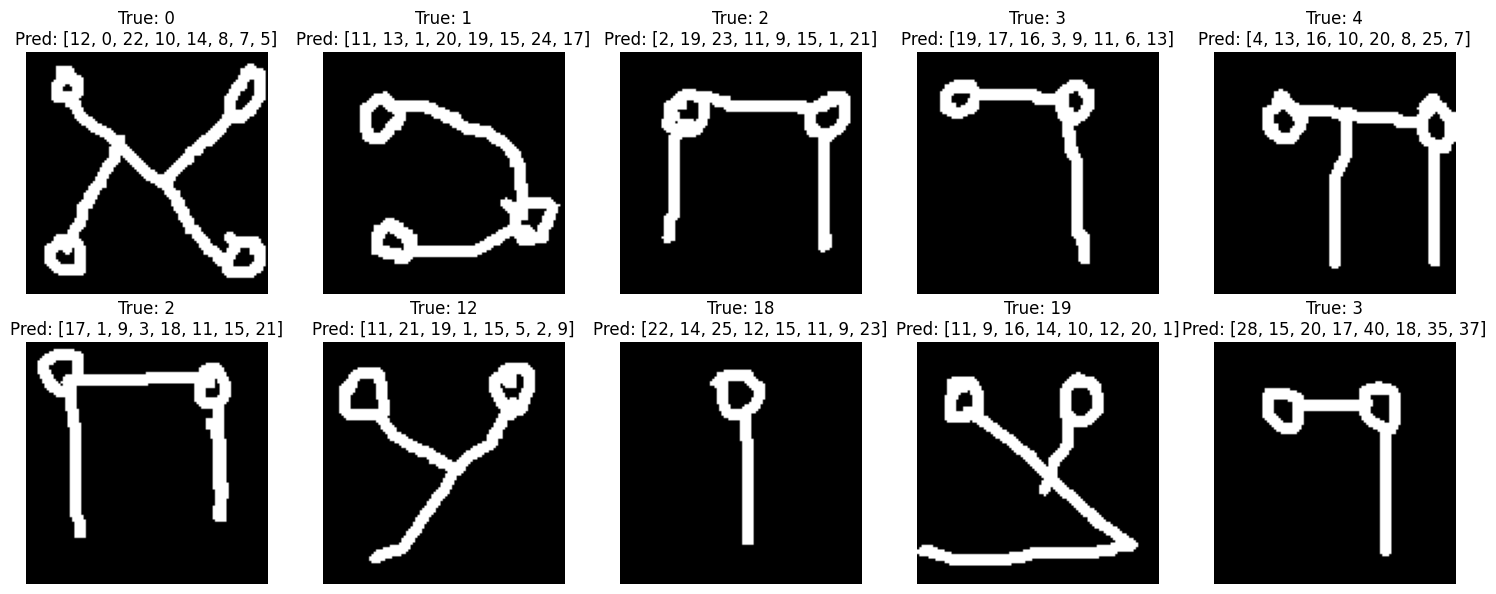

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def display_image(data, alphabet, character, image_id, ax, title=""):
    """
    Display a single image from the provided data.
    """
    image = data[alphabet][image_id,0,...]
    ax.imshow(np.squeeze(image), cmap='gray')
    ax.set_title(title)
    ax.axis('off')

def val_and_collect(test_data, model, alphabet, k=8):
    x_test_train, y_test_train, x_test_valid, y_test_valid, label_dict = process_test_data(test_data, alphabet)
    counts = [0 for _ in range(k)]
    correct_predictions = []
    incorrect_predictions = []

    train_outputs = []
    model.eval()  # evaluation mode
    with torch.no_grad():
        for train_idx in range(len(x_test_train)):
            train_outputs.append(model(x_test_train[train_idx].unsqueeze(0)))
        lables = []
        lables_in = []
        for test_idx in range(len(x_test_valid)):
            distances = []
            output2 = model(x_test_valid[test_idx].unsqueeze(0))
            for train_idx in range(len(x_test_train)):
                dist = (train_outputs[train_idx] - output2).pow(2).sum(1)
                distances.append(dist.item())

            value, index = torch.topk(torch.tensor(distances), k, largest=False)

            true_label = y_test_valid[test_idx]
            predicted_indices = index.tolist()

            if true_label in predicted_indices[:k] and true_label not in lables:
                correct_predictions.append((true_label, predicted_indices, test_idx))
                lables.append(true_label)
            elif true_label not in predicted_indices[:k] and true_label not in lables_in:
                incorrect_predictions.append((true_label, predicted_indices, test_idx))
                lables_in.append(true_label)
            for i in range(k):
                if (true_label in predicted_indices[:i+1]):
                    counts[i] += 1

    return counts, len(x_test_valid), [c/len(x_test_valid) for c in counts], correct_predictions, incorrect_predictions

def evaluate_and_display_results(test_data, model, k):
    counts = [0 for _ in range(k)]
    total = 0
    correct_predictions = []
    incorrect_predictions = []
    alphabets = list(test_data['unseen_images'].keys())

    for alphabet in alphabets[::-1]:
        alphabet_counts, alphabet_total, _, correct, incorrect = val_and_collect(test_data, model, alphabet, k)
        counts = [sum(x) for x in zip(counts, alphabet_counts)]
        total += alphabet_total
        correct_predictions.extend(correct)
        incorrect_predictions.extend(incorrect)

    print(f"Accuracy for top-{k}: {round(counts[k-1] / total, 2)}")

    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for idx, (true_label, predicted_indices, test_idx) in enumerate(correct_predictions[:5]):
         display_image(test_data['unseen_images'], alphabet, character, test_idx, axs[0, idx], f"True: {true_label}\nPred: {predicted_indices}")
    for idx, (true_label, predicted_indices, test_idx) in enumerate(incorrect_predictions[:5]):
         display_image(test_data['unseen_images'], alphabet, character, test_idx, axs[1, idx], f"True: {true_label}\nPred: {predicted_indices}")

    axs[0, 0].set_ylabel('Correct', fontsize=12)
    axs[1, 0].set_ylabel('Incorrect', fontsize=12)

    plt.tight_layout()
    plt.show()

evaluate_and_display_results(data_dict_test, mined_embedding_net, 8)

# Task 2: rotation problem

In [ ]:
# load the test data for task 2:
# the structure of the test data of task 2 is exactly the same as for task 1,
# but now the images are rotated by an unknown angle between 0 and 360 degrees.
data_dict_test_task2 = load_data('test_data_task2.pkl')

In [ ]:
data_dict_test_task2.keys()

In [ ]:
# solution and evaluation of task 2:

# Task 3: Domain knowledge injection

In [ ]:
# load the test data for task 3:
# the structure of the data of task 3 is exactly the same as for task 1, but now our the loaded dictionary contains some additional keys.
# These additional keys will be explained in the cells below:

data_dict_test_task3 = load_data('test_data_task3.pkl')
print(data_dict_test_task3.keys())

In [ ]:
# The keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels' are the same as for task 1, and the structure of the data is exactly the same.

# The key 'unseen_images_preceding_types' maps to the type of the preceding character in the sequence where the unseen image was observed, for each alphabet.
# The key 'character_to_type_mapping' maps to the mapping of each character to its type, for each alphabet.
# The key 'type_following_probs' maps to the probabilities of each character type being followed by another character type, for each alphabet.

In [ ]:
# examples:

alphabet = np.random.choice(list(data_dict_test_task3['unseen_images_preceding_types'].keys()))
print(f'Alphabet: {alphabet}')


preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]  # a list
print(f'Some character types that preceded unseen images from the {alphabet} alphabet: {np.random.choice(preceding_character_types_alphabet, size=5)}')
print(f'There are {len(preceding_character_types_alphabet)} preceding character types in the {alphabet} alphabet, and {len(data_dict_test_task3["unseen_images"][alphabet])} unseen images.')


character_to_type_mapping_alphabet = data_dict_test_task3["character_to_type_mapping"][alphabet]
# this is a dict, with as keys the characters and as values the types
random_character = np.random.choice(list(character_to_type_mapping_alphabet.keys()))
print(f'Type of {random_character} from the {alphabet} alphabet: {character_to_type_mapping_alphabet[random_character]}')



type_following_probs_alphabet = data_dict_test_task3["type_following_probs"][alphabet]  # a dict of dicts
preceding_type = np.random.choice(list(type_following_probs_alphabet.keys()))
following_type = np.random.choice(list(type_following_probs_alphabet[preceding_type].keys()))
print(f'Probability of a character of type {following_type} following a character of type {preceding_type} in the {alphabet} alphabet: {type_following_probs_alphabet[preceding_type][following_type]}')
